<a href="https://colab.research.google.com/github/natexjake/OllopaCorporation/blob/main/OOP_Facedetection_Media_Pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 12.9 MB/s eta 0:00:00


In [2]:
!pip install retina-face

In [3]:
!pip install matplotlib

In [4]:
!pip install Pillow


In [5]:
from PIL import Image
from PIL.Image import fromarray
from retinaface import RetinaFace
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive
import math
import PIL
import io
import os
import sys
import cv2
import html
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mediapipe as mp

If you install the libraries permanently you can remove the comment

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# package_path = '/content/packages'
# sys.path.insert(0,package_path)

In [ ]:
# import mediapipe as mp

In [9]:
def browse_photos():
    print('\n')
    print("Browsing photos...")
    uploaded = files.upload()

    for filename, file_content in uploaded.items():
      # Decode the file content as an image
      nparr = np.frombuffer(file_content, np.uint8)
      img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      resp = RetinaFace.detect_faces(img_path=filename)  # Use the filename as the path
      x1, y1 = resp["face_1"]["landmarks"]["right_eye"]
      x2, y2 = resp["face_1"]["landmarks"]["left_eye"]
      a = abs(y1 - y2)
      b = abs(x2 - x1)
      c = math.sqrt(a * a + b * b)
      cos_alpha = (b * b + c * c - a * a) / (2 * b * c)
      alpha = np.arccos(cos_alpha)
      alpha = (alpha * 180) / math.pi
      aligned_img = fromarray(img_rgb)
      aligned_img = np.array(aligned_img.rotate(alpha))
      aligned_img_rgb = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)

      # Face extraction
      mp_face_mesh = mp.solutions.face_mesh
      face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
      results = face_mesh.process(aligned_img_rgb[:, :, ::-1])
      landmarks = results.multi_face_landmarks[0]
      face_oval = mp_face_mesh.FACEMESH_FACE_OVAL
      df = pd.DataFrame(list(face_oval), columns=["p1", "p2"])
      routes_idx = []
      p1 = df.iloc[0]["p1"]
      p2 = df.iloc[0]["p2"]

      for i in range(0, df.shape[0]):
          obj = df[df["p1"] == p2]
          p1 = obj["p1"].values[0]
          p2 = obj["p2"].values[0]
          current_route = []
          current_route.append(p1)
          current_route.append(p2)
          routes_idx.append(current_route)

      routes = []
      for source_idx, target_idx in routes_idx:
          source = landmarks.landmark[source_idx]
          target = landmarks.landmark[target_idx]
          relative_source = (int(source.x * aligned_img_rgb.shape[1]), int(source.y * aligned_img_rgb.shape[0]))
          relative_target = (int(target.x * aligned_img_rgb.shape[1]), int(target.y * aligned_img_rgb.shape[0]))
          routes.append(relative_source)
          routes.append(relative_target)

      mask = np.zeros((aligned_img_rgb.shape[0], aligned_img_rgb.shape[1]))
      mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
      mask = mask.astype(bool)

      out = np.zeros_like(aligned_img_rgb)
      out[mask] = aligned_img_rgb[mask]

      # Display the manipulated image
      # cv2_imshow(out)

      img = out.copy()
      mp_face_mesh = mp.solutions.face_mesh
      face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
      results = face_mesh.process(img)
      landmarks = results.multi_face_landmarks[0]
      img = out.copy()

      lip_landmarks = []
      for source_idx, target_idx in mp_face_mesh.FACEMESH_LIPS:
          source = landmarks.landmark[source_idx]
          target = landmarks.landmark[target_idx]

          relative_source = (int(source.x * img.shape[1]), int(source.y * img.shape[0]))
          relative_target = (int(source.x * img.shape[1]), int(source.y * img.shape[0]))
          lip_landmarks.append((source, target))

          cv2.line(img, relative_source, relative_target, color=(255, 255, 255), thickness=2)

      # Convert the image from BGR to RGB format
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Convert the image back to BGR for display using cv2_imshow
      img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

      # Display the image using OpenCV in Colab
      cv2_imshow(img_bgr)

In [10]:
def use_webcam():
    print('\n')
    print("Using webcam...")

    # JavaScript code to capture image from webcam
    js_code = """
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();

        const dataUrl = canvas.toDataURL('image/jpeg', quality);

        // Return the captured image data URL
        return dataUrl;
    }
    """

    # Execute the JavaScript code
    display(Javascript(js_code))

    # Call the JavaScript function to capture the image
    data = eval_js('takePhoto(0.8)')

    # Convert the captured image data URL to an OpenCV image
    img = js_to_image(data)

    # Save the captured image
    filename = 'captured_image.jpg'
    cv2.imwrite(filename, img)
    print('Saved to {}'.format(filename))

    # Display the captured image
    #cv2_imshow(img)

    # You can continue processing the captured image as needed
    img_base = cv2.imread("captured_image.jpg")

    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process(img)
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]

        img = img_base.copy()
        # mp_face_mesh.FACEMESH_LEFT_EYE
        lip_landmarks = []
        for source_idx, target_idx in mp_face_mesh.FACEMESH_LIPS:
          source = landmarks.landmark[source_idx]
          target = landmarks.landmark[target_idx]

          relative_source = (int(source.x * img.shape[1]), int(source.y * img.shape[0]))
          relative_target = (int(source.x * img.shape[1]), int(source.y * img.shape[0]))
          lip_landmarks.append((source, target))

          cv2.line(img, relative_source, relative_target, color = (255, 255, 255), thickness =2)

        # Convert the image from BGR to RGB format
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert the image back to BGR for display using cv2_imshow
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        # Display the image using OpenCV in Colab
        cv2_imshow(img_bgr)

        # Assign the converted image to a variable
        converted_image = img_bgr
    else:
        print("No face landmarks detected in the image.")

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # # get OpenCV format image
  img = js_to_image(data)
  # # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  cv2.imwrite(filename, img)

  return filename

  #Check if the choice is "2" (capture image from the camera)
  if choice == "2":
    try:
      filename = take_photo('photo.jpg')
      print('Saved to {}'.format(filename))

      # Show the image which was just taken.
      display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))



Face Detection Program
----------------------
1. Upload an image
2. Capture an image from the camera
Enter your choice (1 or 2): 1


Browsing photos...


Saving x163202_tk1_00030hero.jpg to x163202_tk1_00030hero (1).jpg


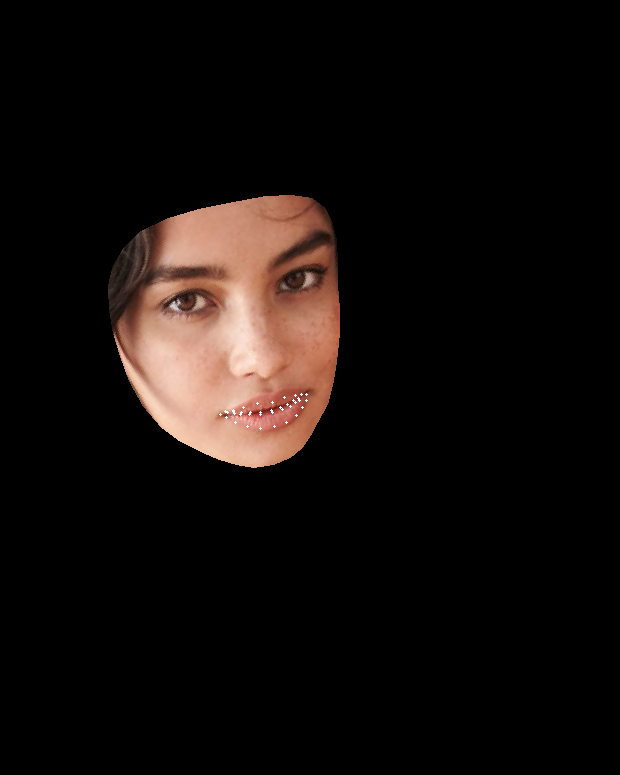

Do you want to try again? (yes/no): no


In [11]:
def main():
    while True:
        print("Face Detection Program")
        print("----------------------")
        print("1. Upload an image")
        print("2. Capture an image from the camera")
        choice = input("Enter your choice (1 or 2): ")

        if choice == "1":
            browse_photos()
        elif choice == "2":
            use_webcam()
        else:
            print("Invalid choice. Please try again.")

        try_again = input("Do you want to try again? (yes/no): ")
        if try_again.lower() != "yes":
            break

if __name__ == "__main__":
    main()
